# BioMON: Few-shot Meta-learning Architectures with Classification Base Learners for Biomedical Datasets.
Manos Chatzakis (emmanouil.chatzakis@epfl.ch), Lluka Stojollari (lluka.stojollari@epfl.ch)

This notebook processes the results of the training and evaluation of BioMON along with other algorithms and creates the figures of the report. 

## Get Started!

Make sure the results are generated and that the required packages are installed.

In [1]:
# To install dependencies:
# %pip3 install -r requirements.txt

# To generate the results:
# %./run_all.sh # Make sure to run this with a GPU, else, it might take a while

## Imports and utilities

Make sure to install the required packages to import the following libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import csv

RESULTS_DIR = "./results/final"
SAVE_PLOTS_DIR = "./plots"

## BioMON Training and Variatons comparisons

In this section, we explore the data from the training of various BioMON versions, and plot our results. Moreover, we compare the performance of different BioMON heads.

### Finetuning the MLP model

As a Neural Network model, the MLP must be finetuned to find the best parameters. The experiments scripts has run and generated results for various versions of the MLP model. We will select the best MLP version based on which parameter version lead bioMON to the best results. 

In [3]:
# TODO!

### Finetuning KNN

We do not know before-hand which KNN model achieves the best result. Thus, we tune on the k value.

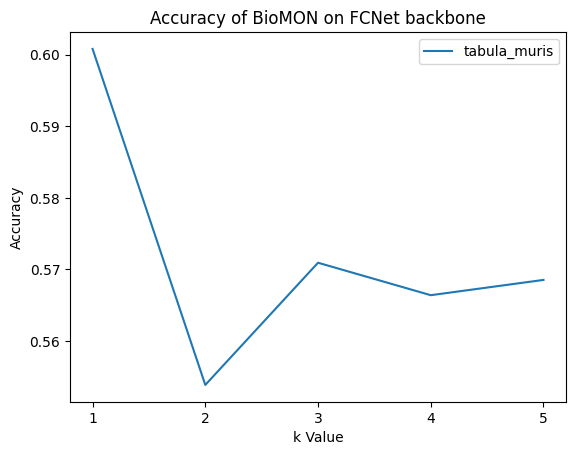

Best knn per dataset {'tabula_muris': '1NN'}


In [4]:
n_way = 5
n_shot = 5
n_query = 15

backbone = "FCNet"
datasets = ["tabula_muris"]
knn = ["1", "2", "3", "4", "5"]

best_knn = {}

for dataset in datasets:
    dataset_accuracies = []
    
    best_acc = -1
    best_model = None
    
    for k in knn:
        path = f"{RESULTS_DIR}/{dataset}/bioMON_{k}NN_{backbone}/{n_way}w{n_shot}s{n_query}q/"
        data = pd.read_csv(path + "test_summary.csv")

        test_line = data.iloc[2]
        acc = test_line["acc_mean"] / 100
        dataset_accuracies.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_model = f"{k}NN"

    best_knn[dataset] = best_model
    
    plt.plot(knn, dataset_accuracies, label=dataset)

plt.xlabel("k Value")
plt.ylabel("Accuracy")
plt.title(f"Accuracy of BioMON on {backbone} backbone")
plt.legend()

plt.savefig(f"{SAVE_PLOTS_DIR}/knn.png")
plt.show()


print("Best knn per dataset", best_knn)

### Finetuning Random Forest

Same for Random Forest: We tune on the number of estimators.

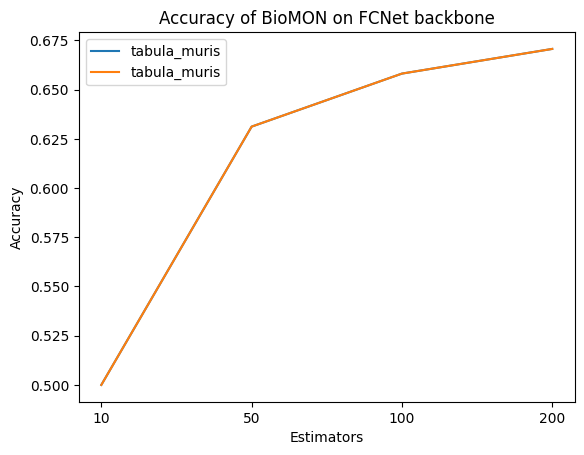

Best rf per dataset {'tabula_muris': 'RF200'}


In [5]:
n_way = 5
n_shot = 5
n_query = 15

backbone = "FCNet"
datasets = ["tabula_muris", "tabula_muris"]
rf = ["10", "50", "100", "200"]

best_rf = {}

for dataset in datasets:
    dataset_accuracies = []
    
    best_acc = -1
    best_model = None
    for r in rf:
        path = f"{RESULTS_DIR}/{dataset}/bioMON_RF{r}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
        data = pd.read_csv(path + "test_summary.csv")

        test_line = data.iloc[2]
        acc = test_line["acc_mean"] / 100
        dataset_accuracies.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_model = f"RF{r}"

    best_rf[dataset] = best_model
    
    plt.plot(rf, dataset_accuracies, label=dataset)
    
plt.xlabel("Estimators")
plt.ylabel("Accuracy")
plt.title(f"Accuracy of BioMON on {backbone} backbone")
plt.legend()

plt.savefig(f"{SAVE_PLOTS_DIR}/rf.png")
plt.show()

print("Best rf per dataset", best_rf)

### Training summaries of the classifiers

Here, we plot the training summaries of all the classifiers used in the evaluation.

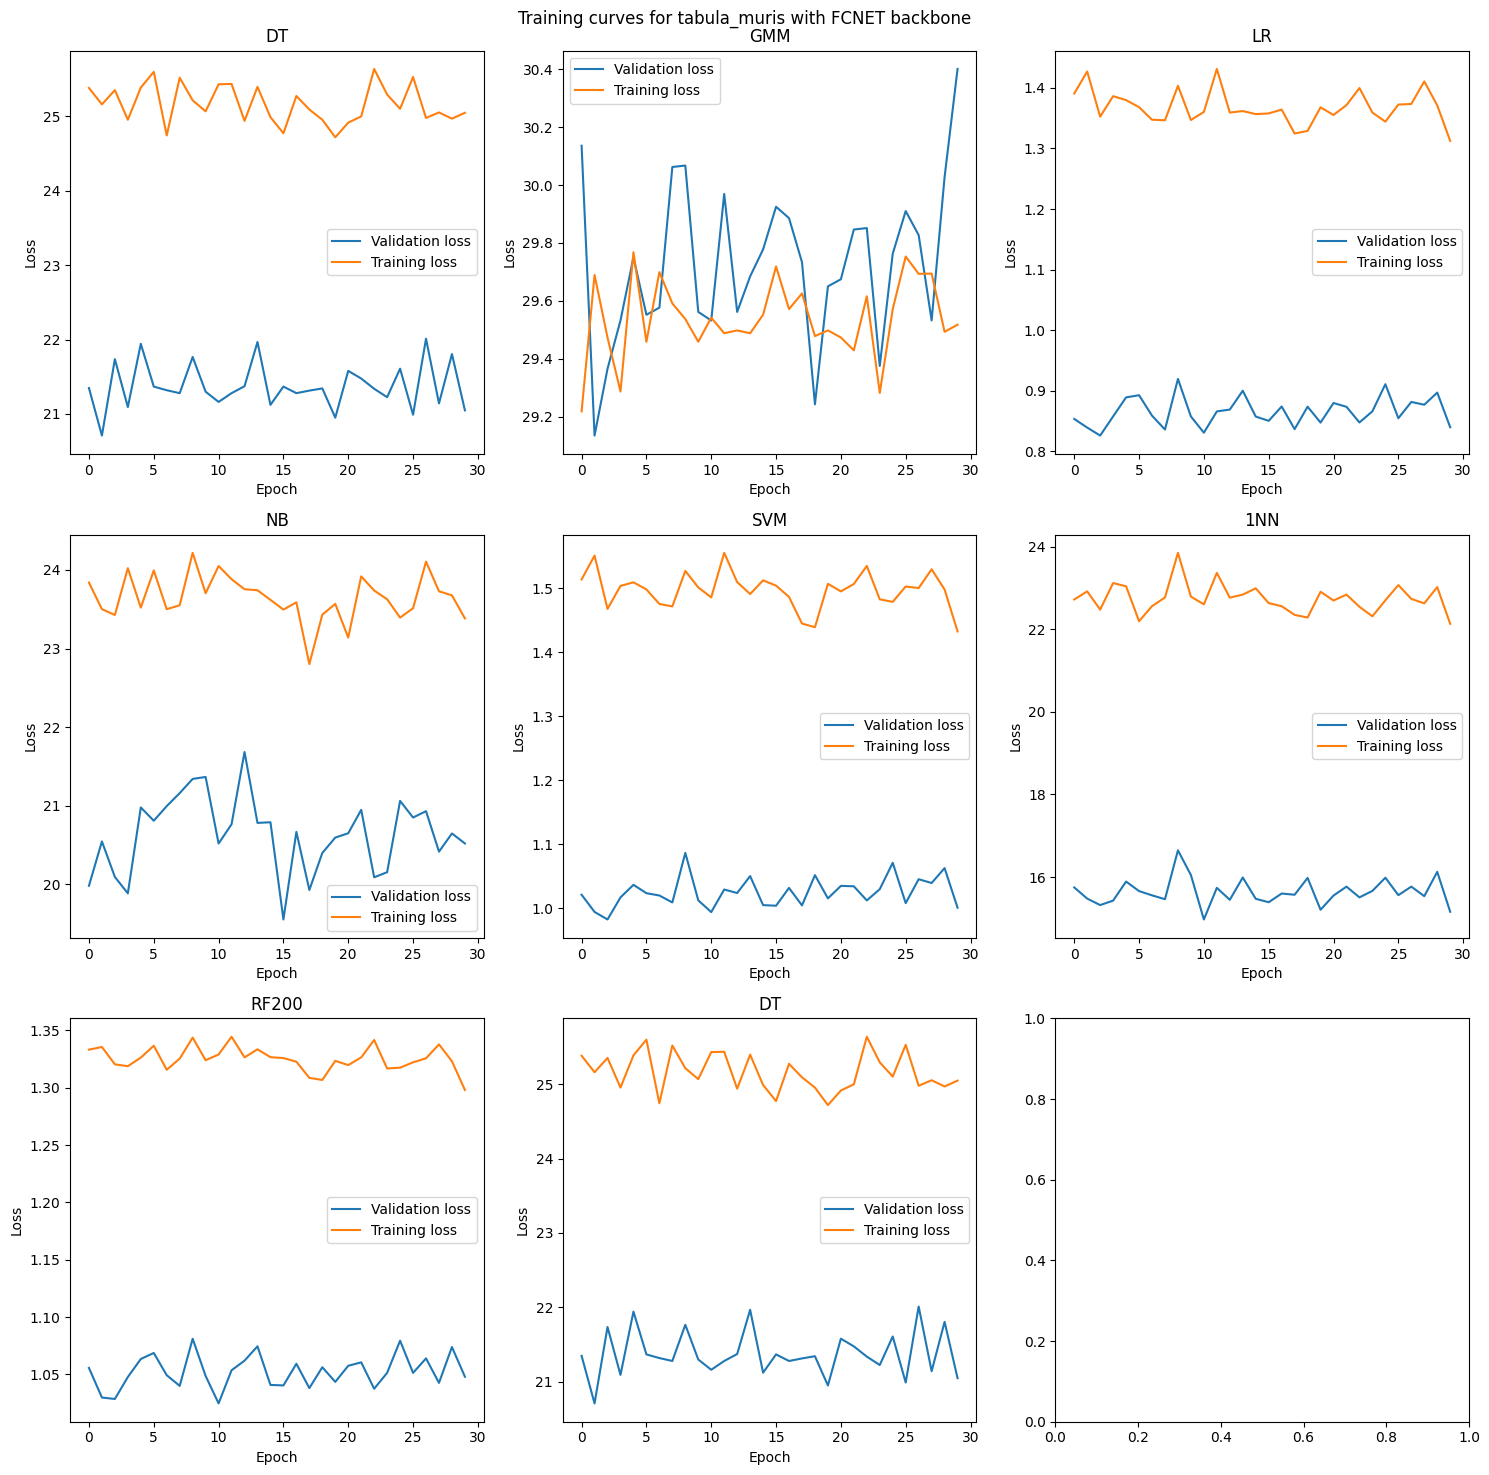

In [6]:
# Compare the training curve of the models
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET"]
datasets = ["tabula_muris"]


for backbone in backbones:
    for dataset in datasets:
        
        classifiers = ["DT", "GMM", "LR", "NB", "SVM", ] + [best_knn[dataset], best_rf[dataset]] + ["DT"] #to be MLP!
        total_classifiers = len(classifiers)

        fig, ax = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"Training curves for {dataset} with {backbone} backbone")

        for index, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "epoch_train_results.csv")

            epochs = data["epoch"].astype(int)
            val_loss = data["val_loss"]
            train_loss = data["train_loss"]

            ax[index // 3, index % 3].plot(epochs, val_loss, label="Validation loss")
            ax[index // 3, index % 3].plot(epochs, train_loss, label="Training loss")
            ax[index // 3, index % 3].set_title(f"{classifier}")
            ax[index // 3, index % 3].set_xlabel("Epoch")
            ax[index // 3, index % 3].set_ylabel("Loss")
            ax[index // 3, index % 3].legend()
            

        fig.savefig(
            f"{SAVE_PLOTS_DIR}/{dataset}_{backbone}_n{n_way}_s{n_shot}_q{n_query}_training_curves.png"
        )
        fig.tight_layout()
        plt.show()
        plt.close()

### Plotting the model accuracy

Here, we plot the performance of each classifier for the training data.

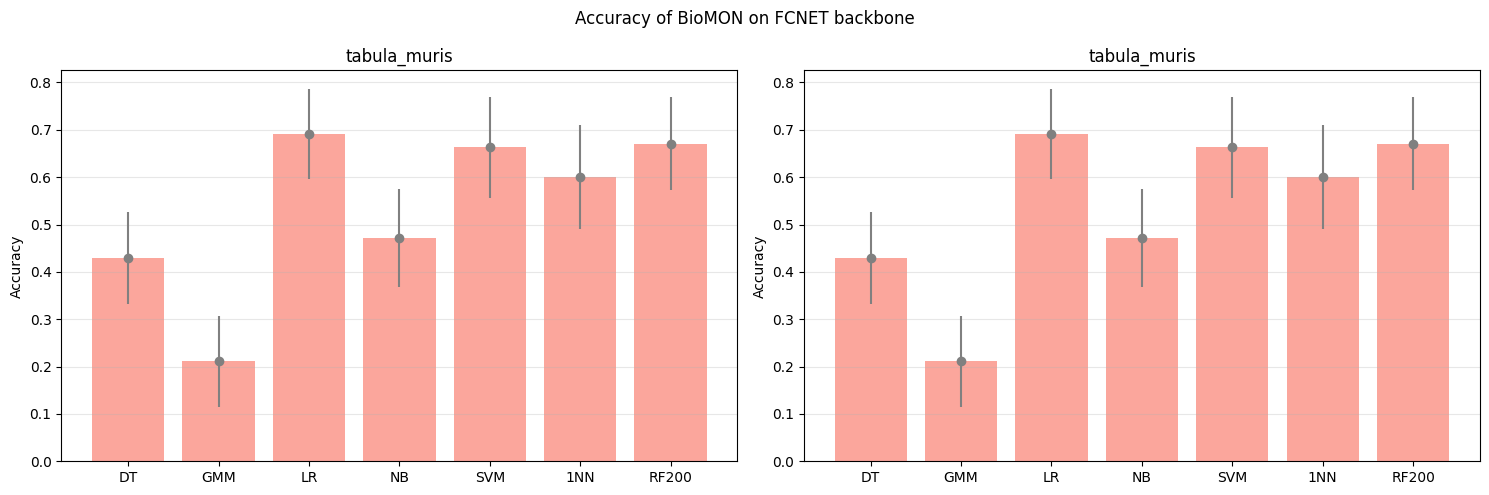

In [23]:
# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbone = "FCNET"
datasets = ["tabula_muris", "tabula_muris"]

fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))
for index, dataset in enumerate(datasets):
    classifiers = (
        [
            "DT",
            "GMM",
            "LR",
            "NB",
            "SVM",
        ]
        + [best_knn[dataset], best_rf[dataset]]
        #+ ["DT"]
    )  # to be MLP!
    total_classifiers = len(classifiers)

    classifier_accuracies = []
    classifier_std = []
    for _, classifier in enumerate(classifiers):
        path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
        data = pd.read_csv(path + "test_summary.csv")
        test_line = data.iloc[2]

        acc = test_line["acc_mean"] / 100
        std = test_line["acc_std"] / 100

        classifier_accuracies.append(acc)
        classifier_std.append(std)

    ax[index].bar(classifiers, classifier_accuracies, color="salmon", alpha=0.7, )
    ax[index].errorbar(
        classifiers, classifier_accuracies, yerr=classifier_std, fmt="o", c="gray"
    )
    ax[index].set_title(f"{dataset}")
    # ax[index].set_xlabel("Classifier")
    ax[index].set_ylabel("Accuracy")
    #ax[index].bar_label(ax[index].containers[0], fmt="%.2f", label_type="center", color="gray")
    ax[index].grid(axis="y", alpha=0.3)
    
#plt.rcParams.update({'font.size': 22})
fig.suptitle(f"Accuracy of BioMON on {backbone} backbone")
fig.tight_layout()
fig.savefig(f"{SAVE_PLOTS_DIR}/classifiers.png")
plt.show()

### Fitting time comparison

Which models needs the least fitting time?

In [ ]:
# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbone = "FCNET"
datasets = ["tabula_muris", "tabula_muris"]

fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))
for index, dataset in enumerate(datasets):
    classifiers = (
        [
            "DT",
            "GMM",
            "LR",
            "NB",
            "SVM",
        ]
        + [best_knn[dataset], best_rf[dataset]]
        #+ ["DT"]
    )  # to be MLP!
    total_classifiers = len(classifiers)

    for _, backbone in enumerate(backbones):
        classifier_accuracies = []
        classifier_std = []
        for _, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")
            test_line = data.iloc[2]


    ax[index].bar(classifiers, classifier_accuracies, color="salmon", alpha=0.7, )
    ax[index].set_title(f"{dataset}")
    ax[index].set_xlabel("Classifier")
    ax[index].set_ylabel("Accuracy")
    
fig.suptitle(f"Accuracy of BioMON on {backbone} backbone")
fig.tight_layout()
fig.savefig(f"{SAVE_PLOTS_DIR}/classifiers.png")
plt.show()

### Fitting time in comparison with total training time

Is it really significant?

In [ ]:
# Compare the overall test accuracies for BioMON

# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
classifiers = ["DT", "KNN", "LR", "MLP", "NB", "SVM", "RF", "NB", "NB"]
datasets = ["tabula_muris", "tabula_muris"]

total_classifiers = len(classifiers)

for backbone in backbones:
    for _, dataset in enumerate(datasets):
        fig, ax = plt.subplots(3, 3, figsize=(15, 10))
        for index, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")

            test_line = data.iloc[0]
            # classifier_accuracies.append(test_line["total_head_fit_time"])
            fit_time = test_line["total_head_fit_time"]
            total_time = test_line["total_training_time"]
            train_time = total_time - fit_time

            ax[index // 3, index % 3].pie(
                [fit_time, train_time],
                labels=["Fit time", "Meta-Train time"],
                autopct="%1.1f%%",
            )
            ax[index // 3, index % 3].set_title(f"{classifier}")

        fig.suptitle(f"Time breakdown for {dataset} with {backbone} backbone")
        fig.tight_layout()
        plt.show()

## Comparison with other few-shot learning algorithms

In this section, we will compare the results of our best-performing bioMON variation with other algorithms. 


### Comparison of the final test accuracy

In [ ]:
algos = ["bioMON_LR", "maml", "protonet"]

n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
datasets = ["tabula_muris", "tabula_muris"]

for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Accuracies for {dataset} dataset")

    for index, backbone in enumerate(backbones):
        algo_accuracies = []
        for _, algo in enumerate(algos):
            path = f"{RESULTS_DIR}/{dataset}/{algo}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "test_summary.csv")

            test_line = data.iloc[2]
            algo_accuracies.append(test_line["acc_mean"])

        ax[index].bar(algos, algo_accuracies)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Algorithm")
        ax[index].set_ylabel("Accuracy")

    fig.tight_layout()
    plt.show()

### Comparison of the total training times of each model

In [ ]:
algos = ["bioMON_LR", "maml", "protonet"]

n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
datasets = ["tabula_muris", "tabula_muris"]

for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Training times for {dataset}")

    for index, backbone in enumerate(backbones):
        algo_accuracies = []
        for _, algo in enumerate(algos):
            path = f"{RESULTS_DIR}/{dataset}/{algo}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")

            test_line = data.iloc[0]
            algo_accuracies.append(test_line["total_training_time"])

        ax[index].bar(algos, algo_accuracies)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Algorithm")
        ax[index].set_ylabel("Training Time (s)")

    fig.tight_layout()
    plt.show()